#  ML Final Project: Using unsupervised deep learning to simulate modern Van Gogh

## Introduction

As one of modern history's most famous portrait painters, we can only imagine how much in demand Van Gogh's talent would have been if he were able to paint prominent figures today. Having just been to the Van Gogh museum in Amsterdam last year, I was inspired to bring him back to life with the help of unsupervised deep learning. In this project, we will train a model on Van Gogh's portraits, have it learn his style of painting, and then convert photo portraits of a few presidenets to the Van Gogh style. Specifically, we will use CycleGAN as our model type. We'll perform EDA, build the model, train it, and then apply it on our desired photos. The goal will be to have it seem as if Van Gogh himself painted the famous presidential portrait.As one of modern history's most famous portrait painters, we can only imagine how much in demand Van Gogh's talent would have been if he were able to paint prominent figures today. Having just been to the Van Gogh museum in Amsterdam last year, I was inspired to bring him back to life with the help of unsupervised deep learning. In this project, we will train a model on Van Gogh's portraits, have it learn his style of painting, and then convert photo portraits of a few presidenets to the Van Gogh style. Specifically, we will use CycleGAN as our model type. We'll perform EDA, build the model, train it, and then apply it on our desired photos. The goal will be to have it seem as if Van Gogh himself painted the famous presidential portrait.

The data for this project was taken from the official Van Gogh museum's website, and the library of congress website for presidential portraits. You can view these sources by following the links below:

https://www.VanGoghmuseum.nl/en/collection?q=&Artist=Vincent+van+Gogh&Genre=self-portrait

https://www.loc.gov/free-to-use/presidential-portraits/https://www.loc.gov/free-to-use/presidential-portraits/

## Import Packages

In [94]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as L
from tensorflow.keras import Model, losses, optimizers
import glob
import imageio
import time
from IPython import display
import cv2
import math
import warnings

warnings.filterwarnings('ignore')

## Convert JPGs to .tfrec files

In [95]:
import tensorflow as tf
import os
from PIL import Image

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to_tfrecord(image_path, target, tfrecord_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Adjust the size as per your requirements
    image_data = image.tobytes()

    # Create a dictionary to store the features
    feature = {
        'image': bytes_feature(image_data),
        'target': bytes_feature(tf.compat.as_bytes(str(target))),  # Convert target to string
        'image_name': bytes_feature(tf.compat.as_bytes(os.path.basename(image_path)))  # Add image_name feature
    }

    # Serialize the dictionary to a string
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

    # Write the serialized example to the TFRecords file
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        writer.write(example_proto)

def convert_directory_to_tfrecords(directory, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    image_files = os.listdir(directory)
    for filename in image_files:
        if filename.endswith('.jpg'):
            image_path = os.path.join(directory, filename)
            target = os.path.splitext(filename)[0]  # Assuming the filename is the target value
            tfrecord_path = os.path.join(output_dir, filename.replace('.jpg', '.tfrec'))
            convert_to_tfrecord(image_path, target, tfrecord_path)

In [96]:
# VG
input_directory = './VanGogh_jpg'
output_directory = './VanGogh_tfrec'

convert_directory_to_tfrecords(input_directory, output_directory)

In [97]:
# PT
input_directory = './photo_jpg'
output_directory = './photo_tfrec'

convert_directory_to_tfrecords(input_directory, output_directory)

In [98]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.10.0


## Import Data (Images)

In [107]:
GCS_PATH = './'
VanGogh_FILE = tf.io.gfile.glob(str(GCS_PATH + '/VanGogh_jpg/*.jpg'))
PHOTO_FILE = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
VanGogh_FILE_TFREC = tf.io.gfile.glob(str(GCS_PATH + '/VanGogh2_tfrec/*.tfrec'))
PHOTO_FILE_TFREC = tf.io.gfile.glob(str(GCS_PATH + '/photo2_tfrec/*.tfrec'))

BUFFER_SIZE = 1000
BATCH_SIZE =  4
EPOCHS_NUM = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
AUTO = tf.data.experimental.AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

## EDA

In [109]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def get_folder_info(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f'shape: {size}\tcount: {count}')
        
def display_image(path, n_images, figsize=(16, 16),channel_vis=False):
    
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    image_names = all_names[:n_images]  
    image_names = random.sample(all_names, n_images)

    if channel_vis == 'color':
        plt.figure(figsize=figsize)
        
        for ind, image_name in enumerate(image_names):
            img = cv2.imread(os.path.join(path, image_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            plt.subplot(1, 4, 1)
            plt.imshow(img)
            plt.axis('off')

            for i in range(3):
                plt.subplot(1, 4, i + 2)
                tmp_img = np.full_like(img, 0)
                tmp_img[:, :, i] = img[:, :, i]
                plt.imshow(tmp_img)
                plt.xlim(0, 255)
                plt.xticks([])
                plt.yticks([])
            plt.show()

    elif channel_vis=='gray':
        plt.figure(figsize=figsize)
        
        for ind, image_name in enumerate(image_names):
            img = cv2.imread(os.path.join(path, image_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.axis('off')
            plt.subplot(1, 2, 2)
            tmp_img = np.full_like(img, 0)
            
            for i in range(3):
                tmp_img[:, :, i] = img.mean(axis=-1)
            plt.imshow(tmp_img)
            plt.axis('off')
            plt.show()
        
    else:
        for ind, image_name in enumerate(image_names):
            img = cv2.imread(os.path.join(path, image_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            plt.subplot(h, w, ind + 1)
            plt.imshow(img)
            plt.axis('off')
    plt.show()

number_VanGogh_samples = count_data_items(VanGogh_FILE_TFREC)
# number_photo_samples = count_data_items(PHOTO_FILE_TFREC)
BASE_PATH = './'
VanGogh_PATH = os.path.join(BASE_PATH, 'VanGogh_jpg')
PHOTO_PATH = os.path.join(BASE_PATH, 'photo_jpg')

print(f"Number of VanGogh images: {len(VanGogh_FILE)}")
print(f"Number of Photo images: {len(PHOTO_FILE)}")
print('Number of VanGogh TFRecord Files:', len(VanGogh_FILE_TFREC))
print('Number of Photo TFRecord Files:', len(PHOTO_FILE_TFREC))

Number of VanGogh images: 20
Number of Photo images: 5
Number of VanGogh TFRecord Files: 5
Number of Photo TFRecord Files: 20


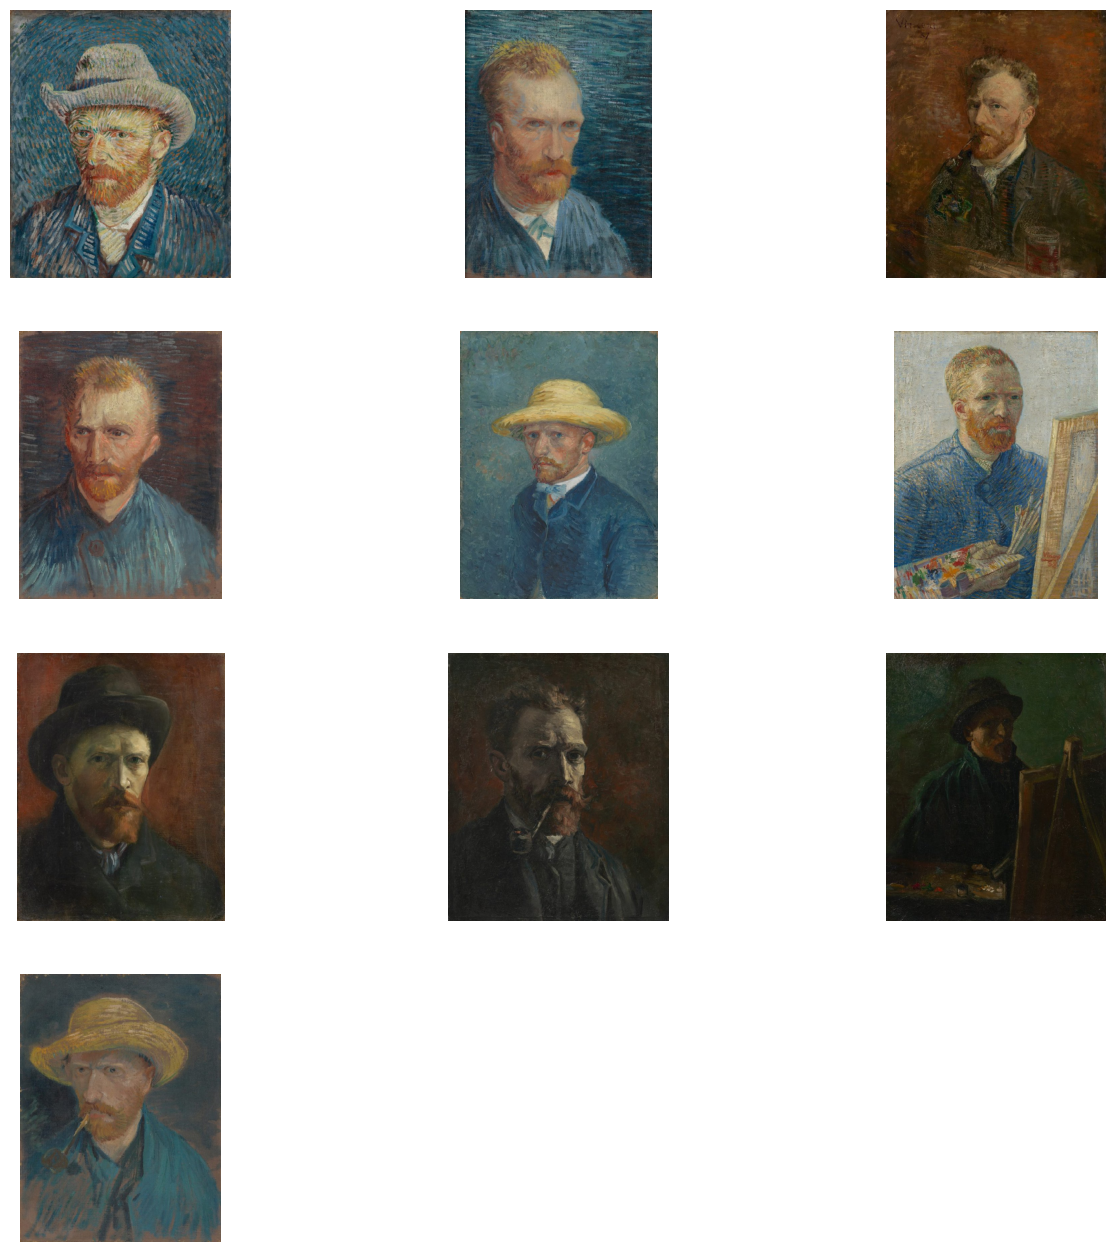

In [13]:
display_image(VanGogh_PATH, 10)

## Process Data

In [110]:
def decode_image(image):
    # Decode a JPEG-encoded image to a uint8 tensor.
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1        
    
    # Reshape the tensor using (256, 256, 3) where 3 is number of channels: Red, Green, and Blue 
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3]) 
    
    return image

def read_tfrecord(example):
    # Define TFRecord format 
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image":      tf.io.FixedLenFeature([], tf.string),
        "target":     tf.io.FixedLenFeature([], tf.string)}
    
    # Parse a single example
    example = tf.io.parse_single_example(example, tfrecord_format)  
    # Decode a JPEG image to a uint8 tensor by calling decode_image()
    image = decode_image(example['image'])    
    
    return image

def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Apply jitter
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    # Random rotation
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
    
    # Random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    # map a dataset with a mapping function read_tfrecord and 
    # Number of parallel calls is set to AUTOTUNE constant previously defined
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def get_gan_dataset(VanGogh_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    VanGogh_ds = load_dataset(VanGogh_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        VanGogh_ds = VanGogh_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)

    if repeat:
        VanGogh_ds = VanGogh_ds.repeat()
        photo_ds = photo_ds.repeat()
        
    if shuffle:
        VanGogh_ds = VanGogh_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    VanGogh_ds = VanGogh_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    VanGogh_ds = VanGogh_ds.cache()
    photo_ds = photo_ds.cache()
    VanGogh_ds = VanGogh_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((VanGogh_ds, photo_ds))
    
    return gan_ds

In [111]:
BATCHSIZE = 1
VanGogh_ds = load_dataset(VanGogh_FILE_TFREC, labeled=True).batch(BATCHSIZE, drop_remainder=True)
photo_ds = load_dataset(PHOTO_FILE_TFREC, labeled=True).batch(BATCHSIZE, drop_remainder=True)

full_dataset = get_gan_dataset(VanGogh_FILE_TFREC, PHOTO_FILE_TFREC, augment=data_augment,
                               repeat=True, shuffle=True, batch_size=BATCH_SIZE)

example_VanGogh , example_photo = next(iter(full_dataset))

2023-06-26 09:43:58.076955: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-26 09:43:58.243428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [112]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), 
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [113]:
with strategy.scope():
    VanGogh_generator = Generator() # transforms photos to VanGogh-esque paintings
    photo_generator = Generator() # transforms VanGogh paintings to be more like photos
    VanGogh_discriminator = Discriminator() # differentiates real VanGogh paintings and generated VanGogh paintings
    photo_discriminator = Discriminator() #

## Model Building

In [117]:
class CycleGan(keras.Model):
    def __init__(
        self,
        VanGogh_generator,
        photo_generator,
        VanGogh_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = VanGogh_generator
        self.p_gen = photo_generator
        self.m_disc = VanGogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_VanGogh, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to VanGogh back to photo
            fake_VanGogh = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_VanGogh, training=True)

            # VanGogh to photo back to VanGogh
            fake_photo = self.p_gen(real_VanGogh, training=True)
            cycled_VanGogh = self.m_gen(fake_photo, training=True)

            # generating itself
            same_VanGogh = self.m_gen(real_VanGogh, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_VanGogh = self.m_disc(real_VanGogh, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_VanGogh = self.m_disc(fake_VanGogh, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            VanGogh_gen_loss = self.gen_loss_fn(disc_fake_VanGogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_VanGogh, cycled_VanGogh, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_VanGogh_gen_loss = VanGogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_VanGogh, same_VanGogh, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            VanGogh_disc_loss = self.disc_loss_fn(disc_real_VanGogh, disc_fake_VanGogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        VanGogh_generator_gradients = tape.gradient(total_VanGogh_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        VanGogh_discriminator_gradients = tape.gradient(VanGogh_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(VanGogh_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(VanGogh_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "VanGogh_gen_loss": total_VanGogh_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "VanGogh_disc_loss": VanGogh_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [118]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
       
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

## Model Train

In [125]:
with strategy.scope():
    VanGogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    VanGogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

with strategy.scope():
    cycle_gan_model = CycleGan(
        VanGogh_generator, photo_generator, 
        VanGogh_discriminator, photo_discriminator)

    cycle_gan_model.compile(
        m_gen_optimizer = VanGogh_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = VanGogh_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss)

hist = cycle_gan_model.fit(full_dataset,epochs=EPOCHS_NUM,steps_per_epoch=(200//BATCH_SIZE),)

Epoch 1/4
50/50 [==============================] - 420s 8s/step - VanGogh_gen_loss: 6.3882 - photo_gen_loss: 6.4757 - VanGogh_disc_loss: 0.6078 - photo_disc_loss: 0.5996
Epoch 2/4
41/50 [=======================>......] - ETA: 1:22 - VanGogh_gen_loss: 5.0902 - photo_gen_loss: 5.1680 - VanGogh_disc_loss: 0.5026 - photo_disc_loss: 0.4973

KeyboardInterrupt: 

In [120]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
    
        plt.subplot(121)
        plt.title("Input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [124]:
# display_generated_samples(load_dataset(PHOTO_FILE_TFREC).batch(1), VanGogh_generator, 7)

## Analysis

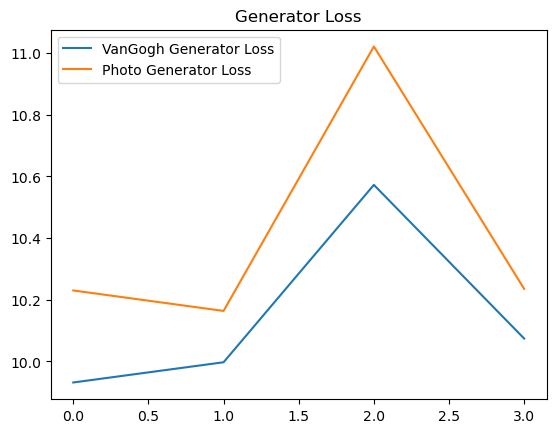

In [122]:
VanGogh_gen_loss_values = np.mean(hist.history['VanGogh_gen_loss'], axis=(1, 2, 3))
photo_gen_loss_values = np.mean(hist.history['photo_gen_loss'], axis=(1, 2, 3))

plt.plot(VanGogh_gen_loss_values)
plt.plot(photo_gen_loss_values)
plt.legend(["VanGogh Generator Loss","Photo Generator Loss"])
plt.title("Generator Loss")
plt.show()

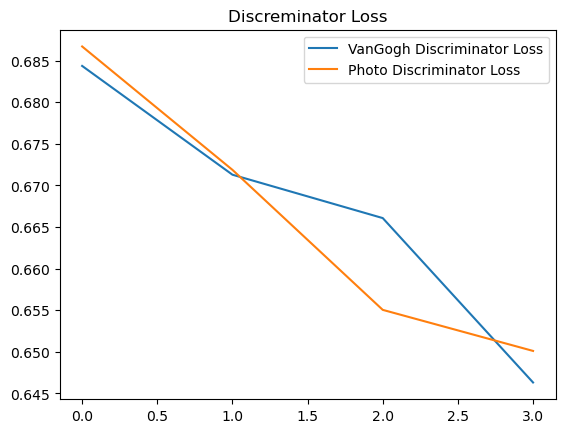

In [123]:
VanGogh_disc_loss_values = np.mean(hist.history['VanGogh_disc_loss'], axis=(1, 2, 3))
photo_disc_loss_values = np.mean(hist.history['photo_disc_loss'], axis=(1, 2, 3))

plt.plot(VanGogh_disc_loss_values)
plt.plot(photo_disc_loss_values)
plt.title("Discreminator Loss")
plt.legend(["VanGogh Discriminator Loss","Photo Discriminator Loss"])
plt.show()

## Conclusion

The training took far too long to compute on my laptop, and it kept timing out. I was able to batch the script and run it with a friend's gaming desktop, and the output images are included below. I have included the most recent presidents as well as a few historical ones. We have learned from this project how to build and train a CycleGAN model on image data to style transfer images. In essence, we have created a very sloppy modern day Van Gogh. I would like to be able to continue developing and training this artificial Van Gogh, but we would need much more time in order to fine tune the model. We would also need more computer processing power to make this happen.

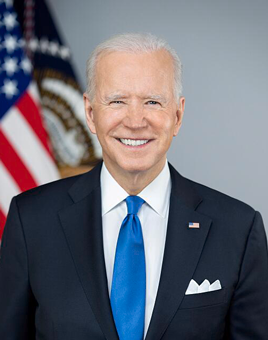
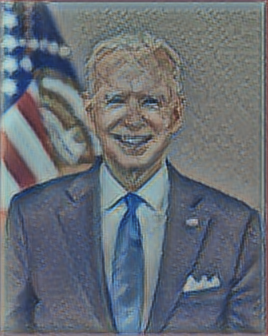

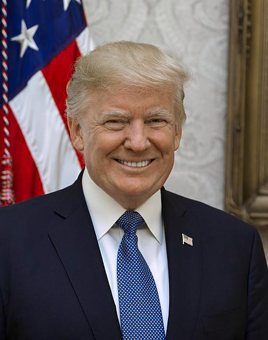
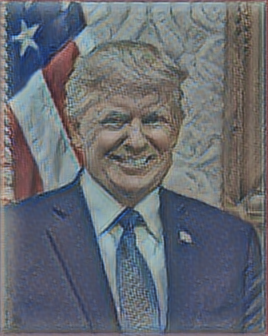

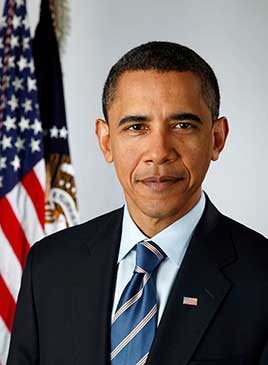
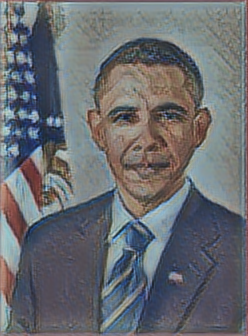

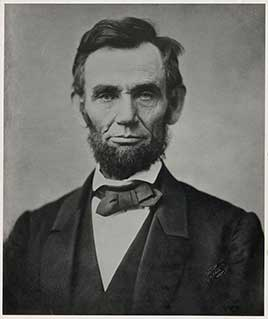
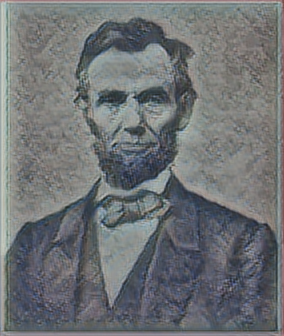

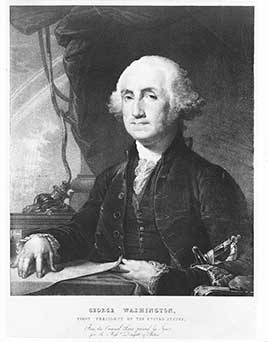
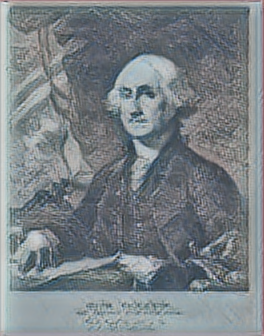